In [1]:
import numpy as np
import pandas as pd
import yaml
import scipy as sp

from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt

from assistive_arm.utils.data_preprocessing import read_headers, smooth_dataframe, interpolate_dataframe

np.set_printoptions(precision=3, suppress=True)

In [13]:
subject = "MIH01"
subject_dir = Path(f"../subject_logs/subject_{subject}")
session_dir = subject_dir / "December_19"

angle_calibration_path = session_dir / "device_height_calibration.yaml"
emg_dir = session_dir / "EMG"

emg_file = emg_dir / "assist_0001_a_2.tsv"
emg_config = dict()

relevant_headers = ["FREQUENCY", "CHANNEL_NAMES"]

emg_config["MAPPING"] = {"Trigno Avanti Duo Mini1_EMG 2": "EMG_RIGHT", "Trigno Avanti Duo Mini2_EMG 1": "EMG_LEFT"}

for header in read_headers(emg_file, 13, delimiter="\t"):
    if header[0] in relevant_headers:
        emg_config[header[0]] = header[1:]

with open(session_dir / "emg_config.yaml", "w") as f:
    yaml.dump(emg_config, f)

with open(angle_calibration_path, 'r') as f:
    angle_calibration = yaml.load(f, Loader=yaml.FullLoader)

In [20]:
relevant_cols = ["TIME", "Trigno Avanti Duo Mini1_EMG 2", "Trigno Avanti Duo Mini2_EMG 1"]

session_data = {}
session_data["MVIC"] = {}
session_data["MVIC"]["LEFT"] = None
session_data["MVIC"]["RIGHT"] = None

session_data["UNPOWERED"] = {}
session_data["ASSISTED"] = {}
session_data["UNPOWERED"]["EMG"] = []
session_data["UNPOWERED"]["MOTOR_DATA"] = []
session_data["UNPOWERED"]["MARKER_DATA"] = []

# Load all session data
profile_to_num = {}

# Handle first motor data
for file_path in sorted(session_dir.iterdir()):
    if file_path.suffix == ".csv":
        if "unpowered" in file_path.stem:
            df = pd.read_csv(file_path, index_col="time")
            session_data["UNPOWERED"]["MOTOR_DATA"].append(df)
        elif "assist" in file_path.stem:
            df = pd.read_csv(file_path, skiprows=2, index_col="time")

            profile_info = read_headers(file_path=file_path, rows=2, delimiter=",")
            time = int(profile_info[0][1])
            force = int(profile_info[1][1])

            profile = f"peak_{time}%_{force}N"

            if profile not in profile_to_num.keys():
                profile_to_num[profile] = []

            num = int(file_path.stem.split("_")[-1])
            profile_to_num[profile].append(num)

            if profile not in session_data["ASSISTED"].keys():
                session_data["ASSISTED"][profile] = {}
                session_data["ASSISTED"][profile]["EMG"] = []
                session_data["ASSISTED"][profile]["MOTOR_DATA"] = []
                session_data["ASSISTED"][profile]["MARKER_DATA"] = []

            session_data["ASSISTED"][profile]["MOTOR_DATA"].append(df)

# Handle second EMG data
for file_path in sorted(emg_dir.iterdir()):
    if file_path.suffix == ".tsv":
        if "unpowered" in file_path.stem:
            if "marker" in file_path.stem:
                # Convert mm to meters
                df = pd.read_csv(file_path, sep="\t", skiprows=11, usecols=["Time", "Hip Left Z", "Hip Right Z"], index_col="Time") / 1000
                session_data["UNPOWERED"]["MARKER_DATA"].append(df)
            else:
                df = pd.read_csv(file_path, sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
                df.rename(columns=emg_config["MAPPING"], inplace=True)
                session_data["UNPOWERED"]["EMG"].append(df)

        elif "assist" in file_path.stem:
            if "marker" in file_path.stem:
                df = pd.read_csv(file_path, sep="\t", skiprows=11, usecols=["Time", "Hip Left Z", "Hip Right Z"], index_col="Time") / 1000
                data_type = "MARKER_DATA"

            else:
                df = pd.read_csv(file_path, sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
                df.rename(columns=emg_config["MAPPING"], inplace=True)
                data_type = "EMG"
                
            num = int(file_path.stem.split("_")[1])

            for profile, nums in profile_to_num.items():
                if num in nums:
                    session_data["ASSISTED"][profile][data_type].append(df)
                    
        elif "MVIC" in file_path.stem:
            df = pd.read_csv(file_path, sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
            df.rename(columns=emg_config["MAPPING"], inplace=True)

            if "Left" in file_path.stem:
                df.drop(columns=["EMG_RIGHT"], inplace=True)
                df._name = "MVIC Left"
                session_data["MVIC"]["LEFT"] = df

            elif "Right" in file_path.stem:
                df.drop(columns=["EMG_LEFT"], inplace=True)
                df._name = "MVIC Right"
                session_data["MVIC"]["RIGHT"] = df

In [21]:
def plot_emg(unfiltered_dfs: pd.DataFrame, filtered_dfs: pd.DataFrame, freq):
    if len(unfiltered_dfs) != len(filtered_dfs):
        raise ValueError("The number of unfiltered and filtered DataFrames must be the same.")

    num_rows = len(unfiltered_dfs)
    single_row = num_rows == 1

    fig, axs = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4 if not single_row else 5))
    axs = axs.reshape(num_rows, -1)  # Ensure axs is always 2D

    for i in range(num_rows):
        time_unfiltered = unfiltered_dfs[i].index.values
        time_filtered = filtered_dfs[i].index.values

        for j in range(4):
            axs[i, j].set_title(f'Iteration {i+1}, {"Filtered" if j % 2 else "Unfiltered"}, {"EMG_RIGHT" if j > 1 else "EMG_LEFT"}')
            axs[i, j].grid(True)

            if j == 0 or j == 2:
                axs[i, j].set_ylabel("EMG signal (mV)")
            axs[i, j].set_xlabel("Time (s)")

        axs[i, 0].plot(time_unfiltered, unfiltered_dfs[i]['EMG_LEFT'], label="Unfiltered EMG_LEFT")
        axs[i, 1].plot(time_filtered, filtered_dfs[i]['EMG_LEFT'], label="Filtered EMG_LEFT")
        axs[i, 2].plot(time_unfiltered, unfiltered_dfs[i]['EMG_RIGHT'], label="Unfiltered EMG_RIGHT")
        axs[i, 3].plot(time_filtered, filtered_dfs[i]['EMG_RIGHT'], label="Filtered EMG_RIGHT")

    plt.tight_layout()
    plt.show()
    
def filter_emg(unfiltered_df: pd.DataFrame, low_pass=10, sfreq=2000, high_band=20, low_band=450):
    """
    emg_dataframe: DataFrame containing the EMG data and time
    low_pass: Low-pass cut off frequency
    sfreq: Sampling frequency
    high_band: High-band frequency for bandpass filter
    low_band: Low-band frequency for bandpass filter
    """
    emg_data = unfiltered_df.copy()

    # Normalize cut-off frequencies to sampling frequency
    high_band_normalized = high_band / (sfreq / 2)
    low_band_normalized = low_band / (sfreq / 2)
    low_pass_normalized = low_pass / (sfreq / 2)

    # Bandpass filter coefficients
    b1, a1 = sp.signal.butter(4, [high_band_normalized, low_band_normalized], btype='bandpass')

    # Lowpass filter coefficients
    b2, a2 = sp.signal.butter(4, low_pass_normalized, btype='lowpass')

    def process_emg(emg):
        # Correct mean
        emg_correctmean = emg - emg.mean()

        # Filter EMG: bandpass, rectify, lowpass
        emg_filtered = sp.signal.filtfilt(b1, a1, emg_correctmean)
        emg_rectified = np.abs(emg_filtered)
        emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)

        # Normalize EMG envelope
        return emg_envelope #/ np.max(emg_envelope)

    # Apply processing to both EMG columns
    envelopes = emg_data.apply(process_emg)
    env_freq = int(low_pass_normalized*sfreq)

    return envelopes, env_freq

### Filter all EMG data

In [22]:
filtered_session_data = deepcopy(session_data)

In [23]:
filtered_session_data["MVIC"]["LEFT"], _ = filter_emg(session_data["MVIC"]["LEFT"])
filtered_session_data["MVIC"]["RIGHT"], _ = filter_emg(session_data["MVIC"]["RIGHT"])

for profile, emg_data in session_data["ASSISTED"].items():
    for i, emg_df in enumerate(session_data["ASSISTED"][profile]["EMG"]):
        filtered_session_data["ASSISTED"][profile]["EMG"][i], _ = filter_emg(emg_df)
for i, emg_df in enumerate(session_data["UNPOWERED"]["EMG"]):
    filtered_session_data["UNPOWERED"]["EMG"][i], _ = filter_emg(emg_df)

In [24]:
max_left = filtered_session_data["MVIC"]["LEFT"].max().values[0]
max_right = filtered_session_data["MVIC"]["RIGHT"].max().values[0]

max_activations = np.array([max_left, max_right])
_, freq = filter_emg(session_data["MVIC"]["LEFT"])

In [25]:
for profile in filtered_session_data["ASSISTED"].keys():
    for i, filtered_emg in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
        filtered_session_data["ASSISTED"][profile]["EMG"][i] = filtered_emg / max_activations

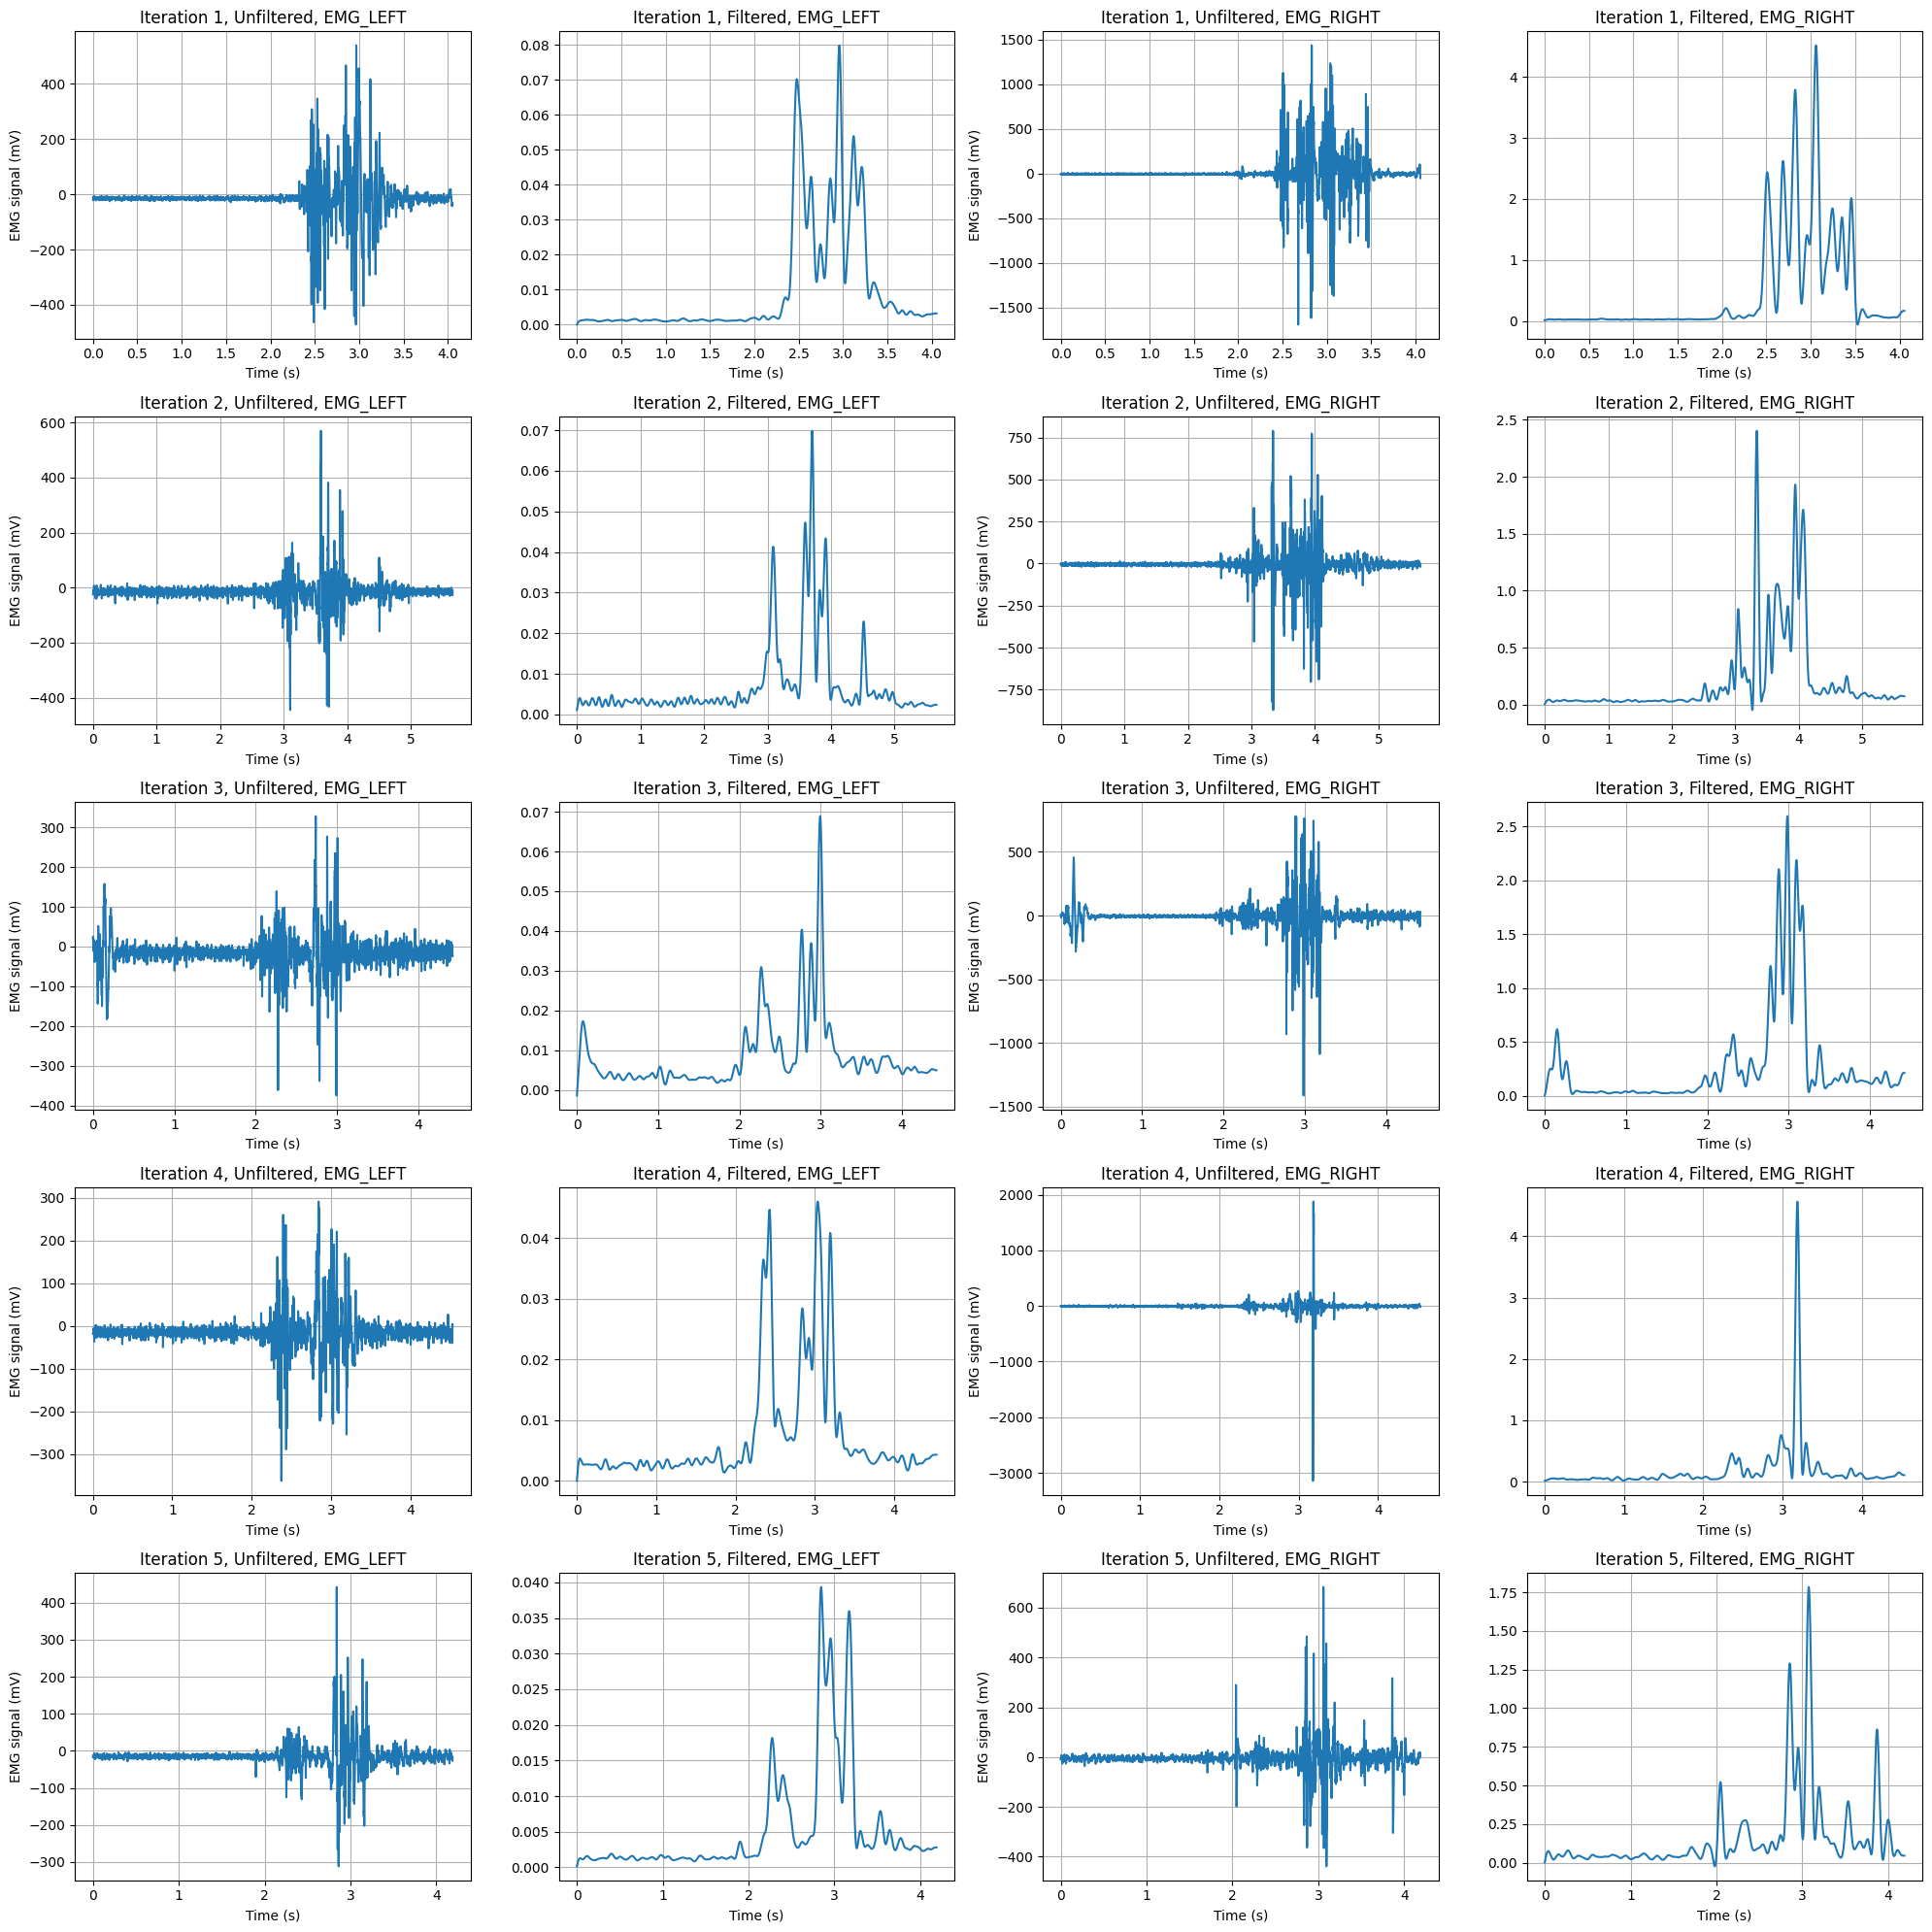

In [27]:
plot_emg(session_data["ASSISTED"]["peak_27%_62N"]["EMG"], filtered_session_data["ASSISTED"]["peak_27%_62N"]["EMG"], freq)

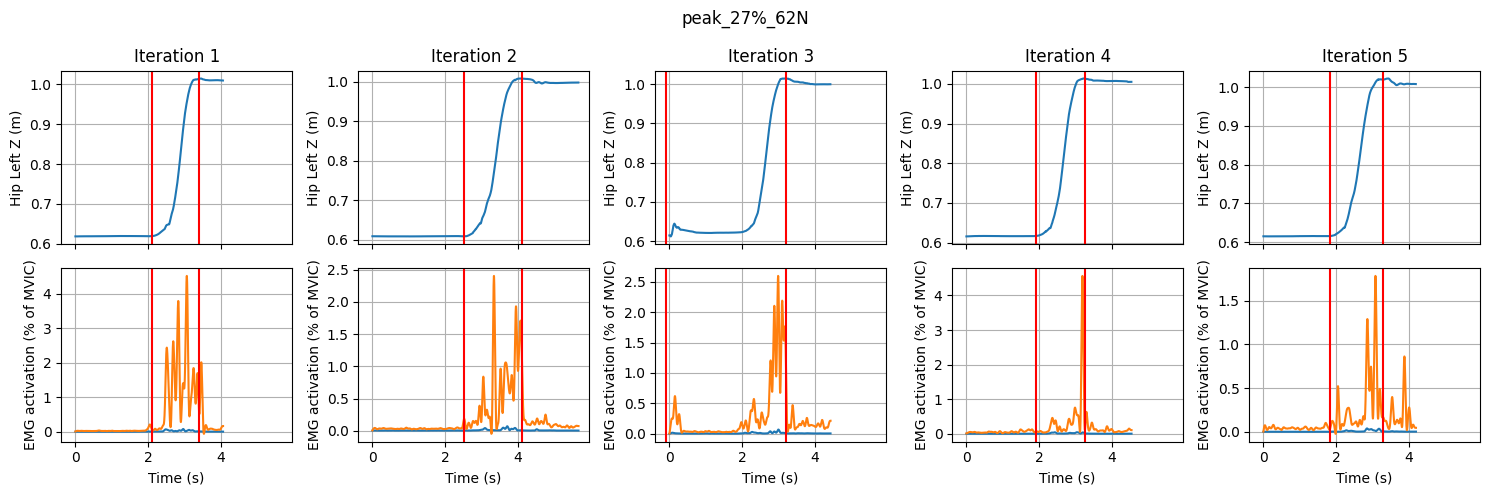

In [29]:
profile = "peak_27%_62N"

hip = filtered_session_data["ASSISTED"][profile]["MARKER_DATA"]
emg_data = filtered_session_data["ASSISTED"][profile]["EMG"]

df_n = len(hip)

# Check if the condition is never met
fig, axs = plt.subplots(2, df_n, figsize=(15, 5), sharex=True)
fig.suptitle(profile)

for i in range(df_n):
    emg_df = emg_data[i]
    df = hip[i]
    hip_vel = smooth_dataframe(df["Hip Left Z"].diff() / df.index.diff(), window_size=30)
    baseline = hip_vel.loc[:1]
    baseline_avg = baseline.mean() + 0.03 # add offset to be safe

    condition = hip_vel > baseline_avg

    first_index = condition.idxmax() - 0.1
    last_index = condition.iloc[::-1].idxmax() + 0.1
    axs[0, i].set_title(f"Iteration {i+1}")
    axs[0, i].plot(df.index, df["Hip Left Z"])
    axs[0, i].set_ylabel("Hip Left Z (m)")
    axs[0, i].axvline(first_index, color="red")
    axs[0, i].axvline(last_index, color="red")
    axs[0, i].grid(True)

    axs[1, i].plot(emg_df.index, emg_df["EMG_LEFT"])
    axs[1, i].plot(emg_df.index, emg_df["EMG_RIGHT"])
    axs[1, i].set_xlabel("Time (s)")
    axs[1, i].set_ylabel("EMG activation (% of MVIC)")
    axs[1, i].axvline(first_index, color="red")
    axs[1, i].axvline(last_index, color="red")
    axs[1, i].grid(True)
plt.tight_layout()

Text(0.5, 0, 'time(s)')

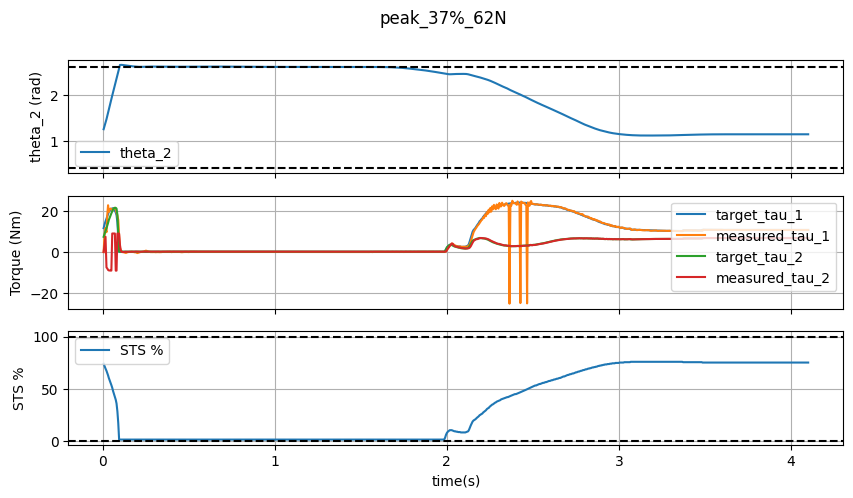

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
fig.suptitle(profile)

ax[0].plot(motor_log.index, motor_log["theta_2"], label="theta_2")
# ax[0].plot(motor_log.index, angle_calibration["theta_2_values"], label="theta_2 at calibration")
ax[0].axhline(y=angle_calibration["new_range"]["min"], linestyle="--", color="black")
ax[0].axhline(y=angle_calibration["new_range"]["max"], linestyle="--", color="black")
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("theta_2 (rad)")


ax[1].plot(motor_log.index, motor_log["target_tau_1"], label="target_tau_1")
ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label="measured_tau_1")
ax[1].plot(motor_log.index, motor_log["target_tau_2"], label="target_tau_2")
ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label="measured_tau_2")
ax[1].grid()
ax[1].legend()
ax[1].set_ylabel("Torque (Nm)")

ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %")
ax[2].axhline(y=100, linestyle="--", color="black")
ax[2].axhline(y=0, linestyle="--", color="black")
ax[2].grid()
ax[2].legend()
ax[2].set_ylabel("STS %")
ax[2].set_xlabel('time(s)')

In [ ]:
cut_off_dfs = []

for df in filtered_dfs:
    baseline = df[df.index < 1]
    threshold = baseline.mean() + 4 * baseline.std()
    first_index_left = df[df > threshold].EMG_LEFT.first_valid_index()
    first_index_right = df[df > threshold].EMG_RIGHT.first_valid_index()

    first_index = min(first_index_left, first_index_right)
    filtered_emg = df.loc[first_index:first_index + 2.5]
    
    cut_off_dfs.append(filtered_emg)

NameError: name 'filtered_dfs' is not defined

In [ ]:
left_mean = 0
left_peak = 0

right_mean = 0
right_peak = 0

for df in cut_off_dfs:
    left_mean += df.EMG_LEFT.mean()
    right_mean += df.EMG_RIGHT.mean()
    left_peak += df.EMG_LEFT.max()
    right_peak += df.EMG_RIGHT.max()

left_mean /= len(cut_off_dfs)
right_mean /= len(cut_off_dfs)
left_peak /= len(cut_off_dfs)
right_peak /= len(cut_off_dfs)

means = np.array([left_mean, right_mean])
peaks = np.array([left_peak, right_peak])

In [ ]:
motor_log = pd.read_csv(session_dir / "1_fixed_force_time_27_force_62.csv", index_col="time")
task_emg = pd.read_csv(session_dir / "Assisted_0001_a_2.tsv", sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
task_emg.rename(columns={"Trigno Avanti Duo Mini1_EMG 2": "EMG_LEFT", "Trigno Avanti Duo Mini2_EMG 1": "EMG_RIGHT"}, inplace=True)

filtered_activation, freq = filter_emg(task_emg)

scaled_activation = filtered_activation / max_activations
scaled_activation = scaled_activation.loc[3.1:5]

In [ ]:
assisted_mean = scaled_activation.mean()
assisted_peaks = scaled_activation.max()

diff_mean = (assisted_mean - means)/means
diff_peaks = (assisted_peaks - peaks)/peaks

print(f"Mean difference:")
print(f"Peak difference:\n{diff_peaks * 100}")

diff_mean

Mean difference:
EMG_LEFT    -13.629622
EMG_RIGHT   -32.236007
dtype: float64
Peak difference:
EMG_LEFT    -17.401734
EMG_RIGHT   -26.825872
dtype: float64


EMG_LEFT    -0.136296
EMG_RIGHT   -0.322360
dtype: float64